# Character RNNs for Medical Entities

In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/snomed/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/snomed/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/snomed/finding.txt', 'data/snomed/body_structure.txt', 'data/snomed/morphologic_abnormality.txt', 'data/snomed/qualifier_value.txt', 'data/snomed/procedure.txt', 'data/snomed/disorder.txt']


In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('a'))
print(letterToTensor('b'))
print(letterToTensor('c'))

print(lineToTensor('adnexa').size())

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([6, 1, 57])


In [3]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        #self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        #output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [4]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

input = lineToTensor('adnexa')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(categoryFromOutput(output))

tensor([[-1.7547, -1.7737, -1.8391, -1.7886, -1.8575, -1.7423]],
       grad_fn=<LogSoftmaxBackward>)
('disorder', 5)


In [5]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = morphologic_abnormality / line = wounds
category = qualifier_value / line = right  to  left
category = qualifier_value / line = elevated
category = finding / line = supine position
category = finding / line = bronchial breath sounds
category = procedure / line = ULTRASOUND
category = disorder / line = respiratory failure
category = body_structure / line = S
category = morphologic_abnormality / line = obstruction
category = morphologic_abnormality / line = narrowing


In [6]:
criterion = nn.NLLLoss()
learning_rate = 0.0005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [7]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 2% (0m 9s) 1.8470 Ultrasound / disorder ✗ (procedure)
10000 5% (0m 18s) 1.8383 ABNORMAL / finding ✗ (qualifier_value)
15000 7% (0m 28s) 1.7110 immediate / qualifier_value ✓
20000 10% (0m 38s) 1.6372 pulmonary / procedure ✗ (qualifier_value)
25000 12% (0m 47s) 1.7317 sclera / disorder ✗ (body_structure)
30000 15% (0m 56s) 1.6923 right / procedure ✗ (qualifier_value)
35000 17% (1m 6s) 1.7576 procedure complications / finding ✗ (disorder)
40000 20% (1m 17s) 1.3969 Cystolithalopaxy / procedure ✓
45000 22% (1m 28s) 1.7831 apraxia / disorder ✗ (finding)
50000 25% (1m 42s) 1.8108 Sex / body_structure ✗ (finding)
55000 27% (1m 53s) 1.3715 collecting system / body_structure ✓
60000 30% (2m 3s) 1.8865 retired / qualifier_value ✗ (finding)
65000 32% (2m 12s) 1.7176 L / qualifier_value ✗ (body_structure)
70000 35% (2m 21s) 1.9214 bizarre behavior / morphologic_abnormality ✗ (finding)
75000 37% (2m 31s) 1.8900 damage / qualifier_value ✗ (morphologic_abnormality)
80000 40% (2m 41s) 1.4159 seizu

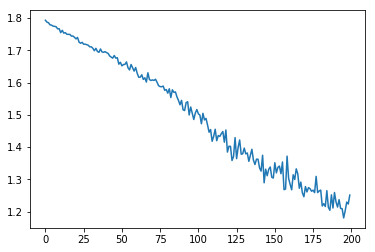

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

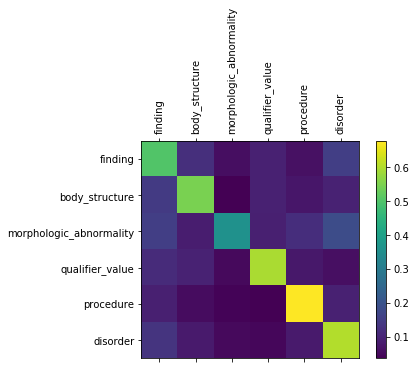

In [10]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [13]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [27]:
predict('seizures')
predict('seizure')
predict('lung')
predict('pneumonia')
predict('adnexa')
predict('aortic valve')
predict('Aortic valve')


> seizures
(-0.94) finding
(-1.34) morphologic_abnormality
(-1.67) body_structure

> seizure
(-1.22) finding
(-1.37) morphologic_abnormality
(-1.83) body_structure

> lung
(-1.22) body_structure
(-1.29) finding
(-1.97) morphologic_abnormality

> pneumonia
(-0.64) disorder
(-1.29) finding
(-2.33) qualifier_value

> adnexa
(-0.86) body_structure
(-1.20) finding
(-2.08) qualifier_value

> aortic valve
(-0.36) body_structure
(-1.81) qualifier_value
(-2.95) finding

> Aortic valve
(-0.47) body_structure
(-1.46) qualifier_value
(-2.74) finding


In [28]:
predict('artherosclerosis')
predict('nodule')
predict('necrotizing enterocolitis')
predict('enterocolitis')


> artherosclerosis
(-0.57) disorder
(-1.19) finding
(-3.04) body_structure

> nodule
(-1.07) body_structure
(-1.14) morphologic_abnormality
(-1.83) qualifier_value

> necrotizing enterocolitis
(-0.09) disorder
(-2.72) finding
(-4.82) procedure

> enterocolitis
(-0.17) disorder
(-2.50) finding
(-3.53) morphologic_abnormality


In [29]:
predict('ex-smoker')
predict('Ex-smoker')
predict('non-smoker')
predict('ex - smoker')
predict('ex smoker')


> ex-smoker
(-1.11) finding
(-1.41) disorder
(-1.61) body_structure

> Ex-smoker
(-1.02) finding
(-1.56) body_structure
(-1.63) qualifier_value

> non-smoker
(-1.16) finding
(-1.31) body_structure
(-1.71) disorder

> ex - smoker
(-0.76) finding
(-1.26) body_structure
(-1.89) disorder

> ex smoker
(-0.83) finding
(-1.30) body_structure
(-1.90) disorder
